#                     Fundamentals of Machine Learning - 2022
#                     Report 2 - Classifying with convnets - CNN
###                          Facundo Sheffield

### Deep Learning approach

In this notebook we will be using a convolutional neural network to classify the grayscale images dataset. We will be using the Keras library to build and train the model.

### Loading data and augmentation:

Lets start by importing some of the libraries we need and loading the data.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [54]:
# Lets load the faces_dict.p file:
with open('faces_dict.p', 'rb') as f:
    faces_dict = pickle.load(f)

Now, because we are using keras and CNN we would like to have the images as 3D arrays, so we will reshape the images to have a depth of 1.

In [ ]:
# Lets augment the data:
# lets start by adding one channel at the end of the image:
new_val = []
for image in faces_dict['images']:

    new_val.append(np.expand_dims(image, axis=2))

faces_dict.update({'images': np.array(new_val)})

Having done that we proceed to split the data into training and testing sets.

In [ ]:
# Lets start by separating into train, test and validation:

from sklearn.model_selection import train_test_split
Full_X_train, X_test, Full_y_train, y_test = train_test_split(faces_dict['images'], faces_dict['target'], test_size=100, random_state=42, stratify=faces_dict['target'])
X_train, X_val, y_train, y_val = train_test_split(Full_X_train, Full_y_train, test_size=80, random_state=42, stratify=Full_y_train)

print(f"Training, validation and test data: {len(X_train)}, {len(X_val)}, {len(X_test)}")

#### Data Augmentation

Lets continue using the same data augmentation.

In [57]:
import random
def add_noise(img):
    '''Adds random noise to an image'''
    VARIABILITY = 0.1
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 1.)
    return img

# Lets augment the data:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # Mx angle for random rotations
    width_shift_range=0.1, # Max horizontal shift
    height_shift_range=0.1, # Max vertical shift
    shear_range=2, # Shear degree
    horizontal_flip=True,  # Mirror
    zoom_range = 0.02, # Zoom
    preprocessing_function=add_noise, # Adds noise
    fill_mode='nearest')

datagen.fit(X_train, augment=True, seed=42)
it = datagen.flow(X_train, y_train, batch_size=32)  # iterator, each instance returns a tuple (x, y) of batch_size images and corresponding labels

A cool thing about using data augmentation on deep learning is that, unlike Random Forest, we can augment the data dinamically. That is to say, we can create new data with the "it" iterator in batches for each epoch. This means that we are constantly feeding the model with new data, and we are not limited by the amount of data we have!

### The Convolutional Neural Network

Now that we have our data ready, we can start building our model. We will be using the Sequential model from Keras. The CNN itself consists of two convolutional layers, each followed by a max pooling (2, 2) layer. We will also be using dropout layers to avoid overfitting. Finally, we have to include two dense layers to classify the images one with relu activation and another with softmax.


For the optimizer we will be using Adam, and for the loss function we will be using categorical crossentropy. Our metric will be accuracy, like with Random Forest.

In [62]:
# lets create our model:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add(Conv2D(64, kernel_size=4, activation='relu', input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Much faster with pooling
model.add(Conv2D(64, kernel_size=3, activation='relu'))
#model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # A bit of dropout to avoid overfitting
model.add(Dense(40, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Lets train the model, using data augmentation
H = model.fit(it, steps_per_epoch=len(X_train)/32, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
6/6 [==============================] - 2s 160ms/step - loss: 3.7411 - accuracy: 0.0091 - val_loss: 3.6881 - val_accuracy: 0.0250
Epoch 2/500
6/6 [==============================] - 1s 116ms/step - loss: 3.6906 - accuracy: 0.0364 - val_loss: 3.6879 - val_accuracy: 0.0250
Epoch 3/500
6/6 [==============================] - 1s 119ms/step - loss: 3.6883 - accuracy: 0.0273 - val_loss: 3.6881 - val_accuracy: 0.0250
Epoch 4/500
6/6 [==============================] - 1s 106ms/step - loss: 3.6900 - accuracy: 0.0318 - val_loss: 3.6874 - val_accuracy: 0.0250
Epoch 5/500
6/6 [==============================] - 1s 108ms/step - loss: 3.6913 - accuracy: 0.0227 - val_loss: 3.6872 - val_accuracy: 0.0250
Epoch 6/500
6/6 [==============================] - 1s 102ms/step - loss: 3.6896 - accuracy: 0.0091 - val_loss: 3.6879 - val_accuracy: 0.0250
Epoch 7/500
6/6 [==============================] - 1s 99ms/step - loss: 3.6856 - accuracy: 0.0318 - val_loss: 3.6872 - val_accuracy: 0.0250
Epoch 8/500
6/

We can see that after 500 epochs we have a validation accuracy of 0.975, which is pretty good. We can also see that because of the way we implemented the data augmentation, the training accuracy is lower that the validation one.

Before plotting the results, lets check a summary of the model:

In [80]:
# model summary:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 61, 61, 64)        1088      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_11 (Flatten)        (None, 12544)           

We see that our model has over 1.6 million trainable parameters, and most of those are in the relu dense layer, which is to be expected. Having said that, lets procceed to plot the accuracy and loss for the training and validation sets.

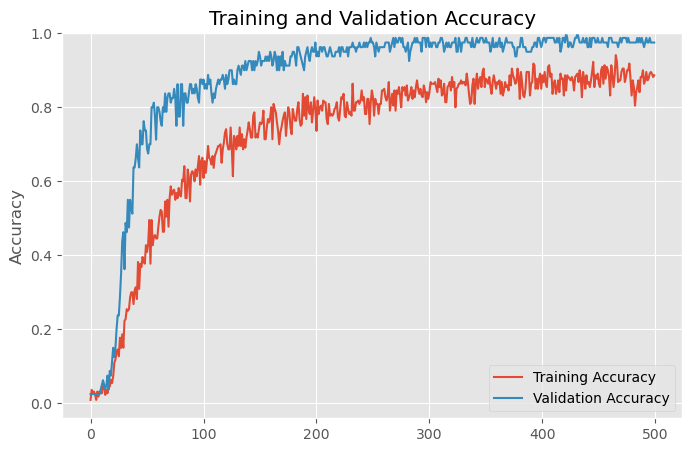

In [64]:
# Lets plot the results:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()


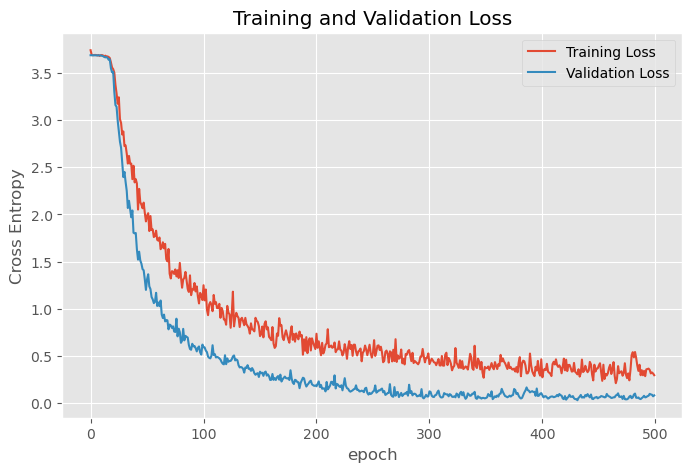

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

From the graphics above we can can infer that adding more epochs would not necessarily improve the model with this amount of data, since the metric and loss seem to stagnate after ~400 epochs. Apart from that, we curiously see that both the validation loss and the validation accuracy give better results than their counterparts. On the one hand this could be because of the way we implemented augmentation, since that reduces the chances of having a very high training accuracy. On the other hand, tensorflow has something interesting to add:

"Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss." 

-https://www.tensorflow.org/tutorials/images/transfer_learning

### Final CNN model

Now, lets use the same CNN but include the validation data into the training set. Since we will have more data to train, and thus more variance, we will increase the number of epochs to 700. Also, since we are using new data, we will need to reapply the data augmentation.

In [69]:
datagen = ImageDataGenerator(
    rotation_range=10,  # Mx angle for random rotations
    width_shift_range=0.1, # Max horizontal shift
    height_shift_range=0.1, # Max vertical shift
    shear_range=2, # Shear degree
    horizontal_flip=True,  # Mirror
    zoom_range = 0.02, # Zoom
    preprocessing_function=add_noise, # Adds noise
    fill_mode='nearest')

datagen.fit(Full_X_train, augment=True, seed=42)
it = datagen.flow(Full_X_train, Full_y_train, batch_size=32)

In [71]:
# Lets train the model, using data augmentation
model = Sequential()
model.add(Conv2D(64, kernel_size=4, activation='relu', input_shape=(64,64,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Much faster with pooling
model.add(Conv2D(64, kernel_size=3, activation='relu'))
#model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # A bit of dropout to avoid overfitting
model.add(Dense(40, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

H = model.fit(it, steps_per_epoch=len(Full_X_train)/32, epochs=700)

Epoch 1/700
9/9 [==============================] - 3s 99ms/step - loss: 3.7256 - accuracy: 0.0133
Epoch 2/700
9/9 [==============================] - 1s 87ms/step - loss: 3.6892 - accuracy: 0.0067
Epoch 3/700
9/9 [==============================] - 1s 92ms/step - loss: 3.6901 - accuracy: 0.0200
Epoch 4/700
9/9 [==============================] - 1s 93ms/step - loss: 3.6932 - accuracy: 0.0200
Epoch 5/700
9/9 [==============================] - 1s 93ms/step - loss: 3.6905 - accuracy: 0.0367
Epoch 6/700
9/9 [==============================] - 1s 88ms/step - loss: 3.6887 - accuracy: 0.0233
Epoch 7/700
9/9 [==============================] - 1s 90ms/step - loss: 3.6889 - accuracy: 0.0267
Epoch 8/700
9/9 [==============================] - 1s 83ms/step - loss: 3.6922 - accuracy: 0.0233
Epoch 9/700
9/9 [==============================] - 1s 88ms/step - loss: 3.6943 - accuracy: 0.0300
Epoch 10/700
9/9 [==============================] - 1s 85ms/step - loss: 3.6857 - accuracy: 0.0367
Epoch 11/700
9/9 [=

Lets plot the results:

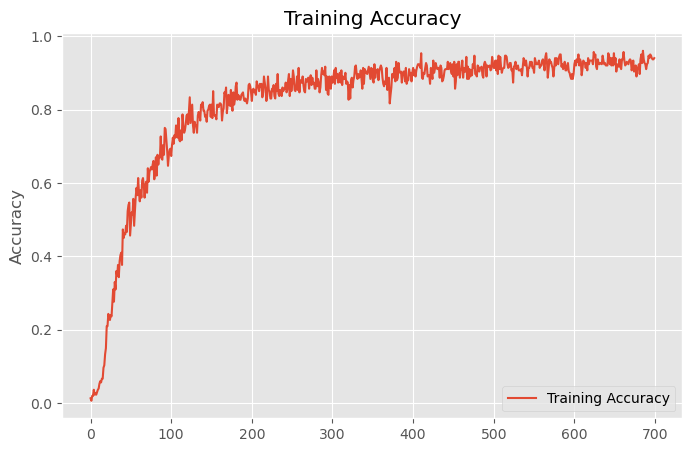

In [75]:
# lets plot the results:
acc = H.history['accuracy']
loss = H.history['loss']

plt.figure(figsize=(8, 5))
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

plt.title('Training Accuracy')
plt.show()


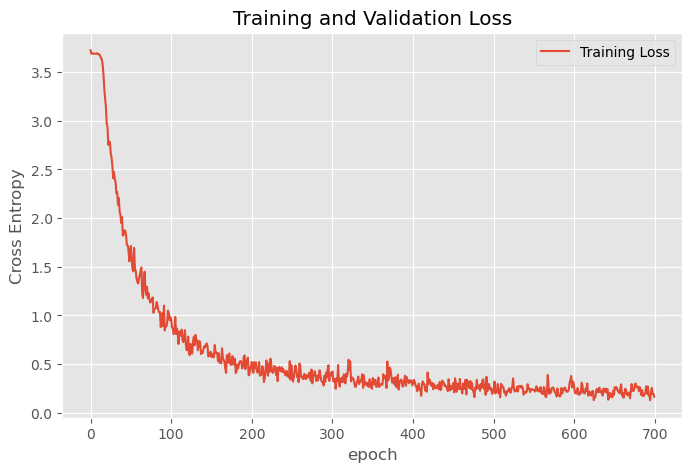

In [77]:
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see that there is not much difference between these graphs and the validation ones. 

Finally, lets export our model to test it with the others.

In [78]:
# Lets export the model:
model.save('CNN_model.h5')

As a final note, there a few ways to potentially improve the results, such as using a different optimizer, or changing the learning rate. I did play around with some of the layers (using different poolings or adding more conv layers, for example) but I did not see any significant improvement.